In [1]:
from uuid import uuid4

import torch
from torchvision import datasets
from torchvision import transforms

import syft as sy

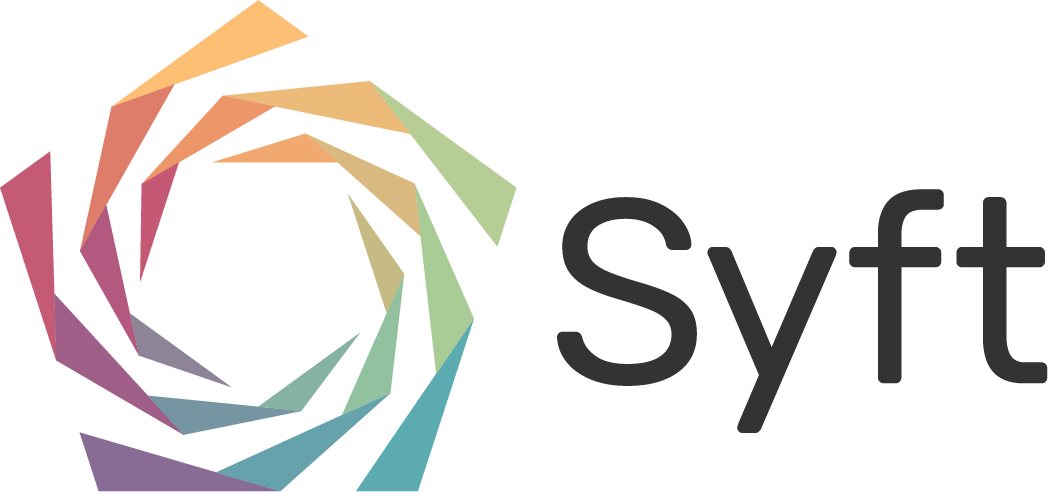

🎤  🎸  ♪♪♪ Starting Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following code to your Duet Partner!

import syft as sy
duet = sy.join_duet(loopback=True)

♫♫♫ > Connecting...

♫♫♫ > CONNECTED!



In [2]:
duet = sy.duet(loopback=True)

---

## Load data

We use a utility function to split the MNIST dataset in two: left and right halves.
Data owner 1 owns the left halves of the images.
In practice, DO1 would already have this dataset, so splitting would not be necessary.

In [3]:
def split_data(dataset, worker_list=None, n_workers=2):

    if worker_list is None:
        worker_list = list(range(0, n_workers))
            
    #counter to create the index of different data samples
    idx = 0 
    
    #dictionary to accomodate the split data
    dic_single_datasets = {}
    for worker in worker_list: 
        """
        Each value is a list of three elements, to accomodate, in order: 
        - data examples (as tensors)
        - label
        - index 
        """
        dic_single_datasets[worker] = [] 

    """
    Loop through the dataset to split the data and labels vertically across workers. 
    Splitting method from @abbas5253: https://github.com/abbas5253/SplitNN-for-Vertically-Partitioned-Data/blob/master/distribute_data.py
    """
    label_list = []
    index_list = []
    index_list_UUID = []
    for tensor, label in dataset:
        height = tensor.shape[-1]//len(worker_list)
        i = 0
        uuid_idx = uuid4()
        for worker in worker_list[:-1]: 
            dic_single_datasets[worker].append(tensor[:, :, height * i : height * (i + 1)])
            i += 1
            
        #add the value of the last worker / split
        dic_single_datasets[worker_list[-1]].append(tensor[:, :, height * (i) : ])
        label_list.append(torch.Tensor([label]))
        index_list_UUID.append(uuid_idx)
        index_list.append(torch.Tensor([idx]))
        
        idx += 1
        
    return dic_single_datasets, label_list, index_list, index_list_UUID

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = datasets.MNIST('mnist', download=True, train=True, transform=transform)
valset = datasets.MNIST('mnist', download=True, train=False, transform=transform)

In [5]:
img, _, _, _ = split_data(trainset)
img = torch.cat(img[0][:25_000])  # get the first split of the data
img_rshp = img.view(img.shape[0], -1)
print(img_rshp.shape)

torch.Size([25000, 392])


In [6]:
val_img, _, _, _ = split_data(valset)
val_img = torch.cat(val_img[0][:5_000])
val_img_rshp = val_img.view(val_img.shape[0], -1)
print(val_img_rshp.shape)

torch.Size([5000, 392])


---

## Send to the data scientist

DS can now use pointers to the data to train a model.
The DS **cannot** access the raw data.

In [7]:
img_rshp.send(duet, searchable=True, tags=["flatten"], description="flattened")
val_img_rshp.send(duet, searchable=True, tags=["flatten_val"], description="flattened validation data")

In [8]:
duet.requests.add_handler(action="accept", tags=[""])

Exception in callback Transaction.__retry()
handle: <TimerHandle when=9911.693564831 Transaction.__retry()>
Traceback (most recent call last):
  File "/home/pavlito/miniconda3/envs/pysyft_0.4/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/home/pavlito/miniconda3/envs/pysyft_0.4/lib/python3.8/site-packages/aioice/stun.py", line 306, in __retry
    self.__future.set_exception(TransactionTimeout())
  File "/home/pavlito/miniconda3/envs/pysyft_0.4/lib/python3.8/asyncio/futures.py", line 246, in set_exception
    raise exceptions.InvalidStateError(f'{self._state}: {self!r}')
asyncio.exceptions.InvalidStateError: FINISHED: <Future finished result=(Message(messa...\x8d\xf8\x8f'), ('172.25.154.90', 58010))>
/mnt/g/Projects/PySyft/src/syft/lib/torch/uppercase_tensor.py:30: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If y

[2021-02-25T21:20:54.535220+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b1694dca53343f2b73cf26febb0b2e2>.
[2021-02-25T21:20:54.786761+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c05767518e4425da875aada97189942>.
[2021-02-25T21:20:55.037531+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04477aab6cd2434886087249757bf9b6>.
[2021-02-25T21:20:55.288476+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7dddc90e511429486570971beced640>.
[2021-02-25T21:20:55.544373+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb4c9188d2e1467c94006df3919fe4f7>.
[2021-02-25T21:20:55.800421+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d060f7ca1547412ea03e38e875b

[2021-02-25T21:21:06.882146+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b37e6c0dd0b04faa9c3da1cfa3643e88>.
[2021-02-25T21:21:07.132342+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 557eb08aa14947ccba388cf80f2cf059>.
[2021-02-25T21:21:07.383980+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 165f9d4b2e214c0c90572e9f27d68ae3>.
[2021-02-25T21:21:07.635456+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c80d65add1b40d098943f56d29c8b33>.
[2021-02-25T21:21:07.890351+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb551eff8c8d49ab8694c1652ee0022f>.
[2021-02-25T21:21:08.143692+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc415d7870b445f682a09e6d7e3

[2021-02-25T21:21:19.221700+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2027b3f31ee641c9b7b077c07dd9f0d3>.
[2021-02-25T21:21:19.473712+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72f605dcf78f4a91ba06876da4aff121>.
[2021-02-25T21:21:19.725543+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c05284530eb0487c879dfc03a60f046f>.
[2021-02-25T21:21:19.975151+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cf62cbcff344aac97bf465c0bafbfb6>.
[2021-02-25T21:21:20.227313+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 396a834ed8ae45aca3e7f46f0f37bdc0>.
[2021-02-25T21:21:20.478402+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c54851681a84eb89b9f4a82ba1

[2021-02-25T21:21:31.534709+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10c2d65ea03b475a90be36e6015638ca>.
[2021-02-25T21:21:31.784275+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 383ff4f5a9b94b34bb6b0ee16bd614e5>.
[2021-02-25T21:21:32.036014+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a680439e0244154a48e4ab324a2312d>.
[2021-02-25T21:21:32.285372+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdea3f8841634380aaa0607f16f67bc2>.
[2021-02-25T21:21:32.536222+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 204ad212c2604365aba6232607949807>.
[2021-02-25T21:21:32.785909+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b347901ae674622aa3f48cae7a

[2021-02-25T21:21:44.339478+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1bc3c45613544ae9549276cd932dca9>.
[2021-02-25T21:21:46.788013+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 425aeb55534b4eaa8ae7d1142ed511da>.
[2021-02-25T21:21:47.039414+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad692fed4bff4c4792275d2195d3b047>.
[2021-02-25T21:21:47.288882+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: caf22cba4bdb4014a156957709ec49db>.
[2021-02-25T21:21:47.543641+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0911ed57495b492b817b6143fe95aa8a>.
[2021-02-25T21:21:47.795989+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15ef046f531740729dc54804b74

[2021-02-25T21:21:58.843263+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: daf1116b5fda43a7b945af0cde38c444>.
[2021-02-25T21:21:59.096959+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a072ca2f41d42beb356f35113d738c5>.
[2021-02-25T21:21:59.350491+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc9d1851719341b6979ea52e7530122e>.
[2021-02-25T21:21:59.602068+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4b2581a38cd4e7f899912ff2469f6bd>.
[2021-02-25T21:21:59.855259+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae45931fe682460f94f1560dd15271cf>.
[2021-02-25T21:22:00.109415+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78f4d756ea2541548291f369c5b

[2021-02-25T21:22:11.133388+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f54f128aaf44cb58de4acc705097d16>.
[2021-02-25T21:22:11.383579+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95e6f6cef0144c339fac524390ef11ba>.
[2021-02-25T21:22:11.632742+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f36b0c3363c4e0aa01b936f9673ed49>.
[2021-02-25T21:22:11.882676+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c99f2666e3e452c91637ecc94f8fa75>.
[2021-02-25T21:22:12.132756+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c583fba0b7d461f86df1c768d15d938>.
[2021-02-25T21:22:12.385315+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d98902b5c8144b65b8cf40c57bd

[2021-02-25T21:22:23.423600+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bf47dc085e7421ab01b8bcf5c853ffc>.
[2021-02-25T21:22:23.674979+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09a758e0831e4550a35a7afc9e67626c>.
[2021-02-25T21:22:23.924598+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66dc034fbd6b4fc0885e966845b3f3c9>.
[2021-02-25T21:22:24.176582+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 965bba4c3fca44809774eaed250d4362>.
[2021-02-25T21:22:24.425943+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99780a8919a344bb9f1aee3709d193b8>.
[2021-02-25T21:22:24.678975+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 369b689f7d714f5787ff4a13578

[2021-02-25T21:22:35.747026+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 135fe6d2708747eba19ac34ac3619d51>.
[2021-02-25T21:22:38.199569+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea48e5840a864ef6a1632388ad9d40e4>.
[2021-02-25T21:22:38.432350+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 354e845b108a4454ad103a05bd932cbb>.
[2021-02-25T21:22:38.664716+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7681f7d03fcc46efb0eee5f3cced5288>.
[2021-02-25T21:22:38.898288+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d84436170ddc4a6d8340d669c7c0a526>.
[2021-02-25T21:22:39.132296+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 098c2cb9c6414970ad5e97b2592

[2021-02-25T21:22:51.749981+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32ae16b9476d4aa5a965cab47911aa9f>.
[2021-02-25T21:22:52.002364+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f831ca1a46304110a49e0471eceb9b4f>.
[2021-02-25T21:22:52.251477+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3308584ddc046e1b8ee0062ee6c5326>.
[2021-02-25T21:22:52.505948+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a98ea35ff6143b4b9b0128c8f2343a2>.
[2021-02-25T21:22:52.755379+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd0e30519be54cdc8be57aa7bb546c62>.
[2021-02-25T21:22:53.005671+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3648ace13f0f434594114d39afd

[2021-02-25T21:23:04.039461+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 805019ed114b4c798de62db1396aeee4>.
[2021-02-25T21:23:04.289745+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66574ae76b96409a80ce5aeb28dee9b7>.
[2021-02-25T21:23:04.543998+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 114a123cbab341dabd7693e6f45827dd>.
[2021-02-25T21:23:04.794499+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e77a5e38b0a04cc38b3527305de1377c>.
[2021-02-25T21:23:05.046776+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 244251287c1d44f280c6375abfa2a0fa>.
[2021-02-25T21:23:05.296766+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2744a3863e6b43ba98f9b16e82a

[2021-02-25T21:23:16.329125+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ac889189ace49c393f75b824960fbf4>.
[2021-02-25T21:23:16.579000+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db4a68a89c9441f8a43b80eb8bc6e314>.
[2021-02-25T21:23:16.828512+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 664995880e20439490f4d4d6401dd40f>.
[2021-02-25T21:23:17.079661+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79454684c84241aea2c92b988a34cf75>.
[2021-02-25T21:23:17.330826+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2947251fb2c641d6a1d470b68fd46e9d>.
[2021-02-25T21:23:17.581006+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 439d719698b646469265291028c

[2021-02-25T21:23:28.662340+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f9c8b38e6e3403d88d6adf498233a2f>.
[2021-02-25T21:23:28.910898+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9621f4e9a5e54f0fb781a70c55fff1dc>.
[2021-02-25T21:23:29.162771+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47d52b4dc8b24eea88dcea369316d4d9>.
[2021-02-25T21:23:29.417530+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4b88fe1e32f49ff94b0e2f2d9e36a19>.
[2021-02-25T21:23:29.668218+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61ac14b5d12e41dbaf24b1c0ce27b3a9>.
[2021-02-25T21:23:29.917920+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bae1094d06644937b9cf3c95863

[2021-02-25T21:23:43.018739+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3dbcece3fa7455da2c68a719844ccc2>.
[2021-02-25T21:23:43.251824+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88f724fdd88040cba1f7ca30cdb6b919>.
[2021-02-25T21:23:43.486364+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a0d333b84848463bbc57bda8654efbe3>.
[2021-02-25T21:23:43.719007+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 272a48ef162b4ac9a4b8782247faa8b2>.
[2021-02-25T21:23:43.952387+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db3eda2160b649cb99b22128a7d20371>.
[2021-02-25T21:23:44.184475+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c07719c0ad841b8807ea728acd

[2021-02-25T21:23:56.955616+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0543d10c75994d638db400f89e87aa52>.
[2021-02-25T21:23:57.207233+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac1ccf5482ab4bb6a0f81f97965442b2>.
[2021-02-25T21:23:57.456568+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c445fd710cd949f29818539a7e5ac72c>.
[2021-02-25T21:23:57.707969+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c159466684945619182c49ff3b3df86>.
[2021-02-25T21:23:57.958142+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8520d575ac724010a1045faac369224c>.
[2021-02-25T21:23:58.209492+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d76c0c391b94421a822e02947d

[2021-02-25T21:24:09.263967+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e94fb8e5df64cc6827bea91a155c66a>.
[2021-02-25T21:24:09.516157+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0ec6b3f5ba94d7b9cd09d46174886f2>.
[2021-02-25T21:24:09.765559+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44a08e32038e4eb9be7cc9cc05503d2e>.
[2021-02-25T21:24:10.017596+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f399bc7f7c7b4868a6cb8bf979e14d0a>.
[2021-02-25T21:24:10.267465+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84f17594c0ff4aea943d2c061a391955>.
[2021-02-25T21:24:10.523947+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49e8d714aa074874942c08baf22

[2021-02-25T21:24:21.552339+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fd26b21209f44d6865ecd28200887dc>.
[2021-02-25T21:24:21.803271+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5418523571e143109a909525dcbf6ced>.
[2021-02-25T21:24:22.053743+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9de25c8d6cea4bfaa76ec2671ea5c1bc>.
[2021-02-25T21:24:22.303119+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18cd1d9ad174421987e818183d4aace1>.
[2021-02-25T21:24:22.555955+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f33668e1d8294a369974cc74331d2608>.
[2021-02-25T21:24:22.805868+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21a5599f14fb4374bc23f164430

[2021-02-25T21:24:33.866672+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03e87d1f15c54746af9dae45167ab28d>.
[2021-02-25T21:24:34.117324+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c21a4fb19d8441198ee1ee041e99c2c>.
[2021-02-25T21:24:34.369115+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07cbcb57a547489dabafd858c7d54f3c>.
[2021-02-25T21:24:34.621433+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71e629a7c3f04b74bbb0079b3463ef63>.
[2021-02-25T21:24:34.871735+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a3da5c7fb7e4b0084b02a522c2af940>.
[2021-02-25T21:24:35.122042+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e00911b0c634d999d5e85b6a95

[2021-02-25T21:24:48.080943+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 334f8d3250ac405fbd9770503b51db2b>.
[2021-02-25T21:24:48.314424+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eca47315ce9c4dc2af7261e0a4d73ca8>.
[2021-02-25T21:24:48.548788+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e82b286720a4120b02ef5569f16869b>.
[2021-02-25T21:24:48.781844+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6930f58e20d24f30b43bcb0af294f9be>.
[2021-02-25T21:24:49.014998+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37f218deef2340a684e6fdc96aff933c>.
[2021-02-25T21:24:49.248935+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68bf5d324e0f4bf78b1f14c62e0

[2021-02-25T21:25:02.356095+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97fbd2d1df584d6c8deea5dbf0bf1acb>.
[2021-02-25T21:25:02.607675+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60c8478b22ba47f7a4dc7acff66c51ec>.
[2021-02-25T21:25:02.856958+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18ce6c5be67042039434fbfaeae320d3>.
[2021-02-25T21:25:03.112722+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63052d96e4e84639b7805b7932a97420>.
[2021-02-25T21:25:03.368523+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7c55d63c2144a96ab6dfc4bf6026f0e>.
[2021-02-25T21:25:03.621154+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7a78f7846e34cccadc2bb093aa

[2021-02-25T21:25:14.675284+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 86029a1c463c4fe5b5891cc65cce3142>.
[2021-02-25T21:25:14.927337+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 581363ed229047598765aedc55dcce48>.
[2021-02-25T21:25:15.177242+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6310b0eadf5c4172a57459e56201d130>.
[2021-02-25T21:25:15.429383+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0453764997204544881f5db4a43c344b>.
[2021-02-25T21:25:15.682949+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1919001d6f6944ee97614ef049273efa>.
[2021-02-25T21:25:15.936511+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70ef9a17ea0a4c3e89e0ffb1f9b

[2021-02-25T21:25:26.983990+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 475e40ec3a66469c89300de4862e4484>.
[2021-02-25T21:25:27.236551+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 535a5d39245e4f969a43ad4d51e240de>.
[2021-02-25T21:25:27.487261+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b049f916a174fc5b7891a5f5afb2197>.
[2021-02-25T21:25:27.739123+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 209199fe846045c3adba54cdaf449cc1>.
[2021-02-25T21:25:27.989649+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ab929c6d570416dae950a356001a7d7>.
[2021-02-25T21:25:28.239491+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3dfaf0226f754bd89c3326f772d

[2021-02-25T21:25:39.296323+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db57d58a1a9744dd81283aa9aeb6940a>.
[2021-02-25T21:25:39.547039+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ebf5c659b40d4512b7cf519df7bb9bd2>.
[2021-02-25T21:25:39.797905+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1449bfa5676c4a05a8a2d6618547fe2f>.
[2021-02-25T21:25:40.056581+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a49bad9b20f54094b1777a17f6e4d6b3>.
[2021-02-25T21:25:40.305064+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 280d4ef75eb64f5bb83ad407b1a7f685>.
[2021-02-25T21:25:40.556475+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 199f6af58f5442ac957a87ea009

[2021-02-25T21:25:53.336613+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12819f80c7d34c14a3b571eed6cf9b51>.
[2021-02-25T21:25:53.569995+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa13eb18225b4ed1a053f8f065682e4d>.
[2021-02-25T21:25:53.802214+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f1c5028b5f4f4b95ab9afd95458191b9>.
[2021-02-25T21:25:54.034686+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 360bb8ba9f41455398b1c70c910c2c2a>.
[2021-02-25T21:25:54.268757+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d82b190b2c0a448bb1ad22adcec2c000>.
[2021-02-25T21:25:54.500857+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ee17b6c2fd042c9b371c1a6c83

[2021-02-25T21:26:07.642438+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e3a2c879efe747cd81c477e94c0b9ac8>.
[2021-02-25T21:26:07.895142+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 739275eecdeb480aa500a42bb8a3a2bc>.
[2021-02-25T21:26:08.145753+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de4077b9fb81472ca1cdcd7c8d29779d>.
[2021-02-25T21:26:08.402648+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22a9738ad34042ecab0a04784ec86a4b>.
[2021-02-25T21:26:08.653977+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 967c1b0e4f5742dc93dc3eb432544632>.
[2021-02-25T21:26:08.911538+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03149370b12e4f1e95862698fe6

[2021-02-25T21:26:19.997626+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf74d079547f437bbc269b0007d00810>.
[2021-02-25T21:26:20.249340+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1630cbc60c934994a47a62e24daaaa0c>.
[2021-02-25T21:26:20.502585+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 355c27e3daab41cf836fe60f197c3bcf>.
[2021-02-25T21:26:20.754964+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ece5dbffd1fc49c18b4c7d50cd5ddbf1>.
[2021-02-25T21:26:21.006714+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7f6de4d43f740549a3571d25f99c7df>.
[2021-02-25T21:26:21.260726+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2ae5a11e80d4e8c8a19f097a44

[2021-02-25T21:26:32.376503+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a352d714b8c41118d4d3c2c409520fc>.
[2021-02-25T21:26:32.630299+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b3a211da91141f7a7fe5426e16e8819>.
[2021-02-25T21:26:32.881652+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75a36070045a40c596ee15d56fc913ba>.
[2021-02-25T21:26:33.135288+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7915384f02b4658a1533b07880fe0fc>.
[2021-02-25T21:26:33.391909+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8895f0353a5e49fe9ac18cd5e357fdd1>.
[2021-02-25T21:26:33.644753+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f3560a778f54a41bb5c545c9d7

[2021-02-25T21:26:44.752586+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a3822dc49a54351bf2a5ecf973504fd>.
[2021-02-25T21:26:45.005287+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65c9b43df34b4536abeb1416d37e451f>.
[2021-02-25T21:26:45.256334+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6dd1bdd54a1a4ecca485896ac869651e>.
[2021-02-25T21:26:45.509499+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c5cc3e3d72648e8ad8a052433a24417>.
[2021-02-25T21:26:45.762235+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09209e0c6d014c458df54faa3040f0f6>.
[2021-02-25T21:26:46.013686+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 198b243cb233418d9e5150a318a

[2021-02-25T21:26:58.644325+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c3062294f9b4781b5118acb4f3f6d38>.
[2021-02-25T21:26:58.877211+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e3d3781996145878fbcc10f4a1b2f4f>.
[2021-02-25T21:26:59.111105+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b631a6caa1bf49f6a3ce8bdaca7eaf4f>.
[2021-02-25T21:26:59.344140+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee6de841e7b84e18a25f4e0a99221187>.
[2021-02-25T21:26:59.575946+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d511ac0822e04ff78a22940b24b2ae99>.
[2021-02-25T21:27:02.025378+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c93c517c72fb471ba1319a7d832

[2021-02-25T21:27:13.124399+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e22a2f1551348dfacebef9aab97bc06>.
[2021-02-25T21:27:13.376172+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bfa685e76e8742ec91fac0f491369a87>.
[2021-02-25T21:27:13.630629+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf32d2aa8f05419680b144fc3c0ad987>.
[2021-02-25T21:27:13.880351+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31184ce057cb48fca424500e364ce47f>.
[2021-02-25T21:27:14.131260+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2221662b22a24aa58a2c9fbaad954eff>.
[2021-02-25T21:27:14.382401+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37699f30706c4e549baffab1117

[2021-02-25T21:27:25.468067+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 543f896a4c0c4ffa89e2473ce3fef422>.
[2021-02-25T21:27:25.719620+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40fca403c59549648943774b0f9225b9>.
[2021-02-25T21:27:25.972740+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6d669a60d064895907d470daf3d526d>.
[2021-02-25T21:27:26.225265+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa496b7aa5774cb2b4039424437e81a1>.
[2021-02-25T21:27:26.477101+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4013d78e86e840a3ae6fff4f2ae1b057>.
[2021-02-25T21:27:26.728249+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dab372fa4a194774b2bded1a7b4

[2021-02-25T21:27:37.813024+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1ddc6d0a2ca40c7be0283a92f11dd3e>.
[2021-02-25T21:27:38.063334+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a391edbc02924ecb8f5657143fc4392a>.
[2021-02-25T21:27:38.313084+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed0d3d20566d49ab9ef7bcec1063f9de>.
[2021-02-25T21:27:38.562876+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 256457e0507243be9e8a60f55fb1358f>.
[2021-02-25T21:27:38.814807+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f61ead9e8ed4163a0946c3b5eb7a101>.
[2021-02-25T21:27:39.065012+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 086440d20c94422c9a2115b925a

[2021-02-25T21:27:50.135207+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a1f5dd977fd46e7ac2e3d142c1209b1>.
[2021-02-25T21:27:50.386427+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a930cef217d641b2a471e679cd717b4e>.
[2021-02-25T21:27:50.636198+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9aa838109d9b483ba422a04886176108>.
[2021-02-25T21:27:50.886496+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22d4a98919d94ea6ae2a0172207bab5a>.
[2021-02-25T21:27:51.135078+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ad560053c69402492dbd17aa36672ab>.
[2021-02-25T21:27:53.587735+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7629531f76c4887acfa3270658

[2021-02-25T21:28:06.137236+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 332e2f3653cd42a4b29adfb0f2af9e12>.
[2021-02-25T21:28:06.389491+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1e769d6f7da4e4db6590d127fbc0724>.
[2021-02-25T21:28:06.641574+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35db7edd36094b7fb3f1bc3765e5b778>.
[2021-02-25T21:28:06.892787+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa3b10a56f144a169ace5086b78df525>.
[2021-02-25T21:28:07.146261+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe8f43f4709342c5a71024e9bc344643>.
[2021-02-25T21:28:07.397912+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 362096868d1942c39867964e840

[2021-02-25T21:28:18.465920+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f0ae46a893540809fccbc295d7949b5>.
[2021-02-25T21:28:18.715872+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e954a25e54964c77b07aa4db6e91883d>.
[2021-02-25T21:28:18.965445+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: adc04ba26c6847389c16f59fca56dd31>.
[2021-02-25T21:28:19.215007+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8e958950cde47d680d5a04ef5fdde88>.
[2021-02-25T21:28:19.468175+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8162962f0bc540638509fb4fbcac7db1>.
[2021-02-25T21:28:19.719842+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c36648ab9cd340f7b3b3f16218e

[2021-02-25T21:28:30.811167+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a65241980ee47dfac4b5ebf078ee737>.
[2021-02-25T21:28:31.064829+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a95d6e9c7c5a4b47b4800deb8c6be0e1>.
[2021-02-25T21:28:31.318605+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0da924ab001c4f8e862ec8719d075259>.
[2021-02-25T21:28:31.573757+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7fc5c2b891364e1daaee2790fc8b4074>.
[2021-02-25T21:28:31.824348+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7663127996a640279ce74ed469c6fa18>.
[2021-02-25T21:28:32.075758+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d793f2375f374bbe8d0b3999110

[2021-02-25T21:28:43.139854+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20aee6a7032f4534b75cb8b54197a3c9>.
[2021-02-25T21:28:43.392432+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 299318502360415d890b850171598b94>.
[2021-02-25T21:28:43.643024+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 853fc3e508b545b895464ec999c0f6dd>.
[2021-02-25T21:28:43.898842+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c461b414427144ee8089f3912d07a9d2>.
[2021-02-25T21:28:44.150712+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d745c522c9344941bafa867ef7aafc09>.
[2021-02-25T21:28:44.405083+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ae7ca025518405da43c4ac2b79

[2021-02-25T21:28:57.595008+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3fca430a76a44eb9b33ebcc288014d0>.
[2021-02-25T21:28:57.826828+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76e8f2588ff74c03a8c7cff0e4a7c88f>.
[2021-02-25T21:28:58.059310+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5be16e5d8e2e46cdbd7962930cbb4140>.
[2021-02-25T21:28:58.292127+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f0c1979a48345eb8a8b05cb90b75281>.
[2021-02-25T21:28:58.526148+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb2e2f501fff4c03b08d610299b099fb>.
[2021-02-25T21:28:58.758205+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e2e5c79992c41d6a1504c38c33

[2021-02-25T21:29:11.443555+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e69eaa05af0d45779221a21fc0b342f3>.
[2021-02-25T21:29:11.693425+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e505ea2a3944fff98b3b2632fa1b780>.
[2021-02-25T21:29:11.945000+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47c16f4e73b84540b7680ba6a242eb4d>.
[2021-02-25T21:29:12.194895+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a78ad4daa414f26ad43725f9000cdec>.
[2021-02-25T21:29:12.445991+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbd7d5e9d5b44770b752f139767a5d2b>.
[2021-02-25T21:29:12.696352+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 96c63681ab364135886cf010ed5

[2021-02-25T21:29:23.746031+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c741a3249264dbfa532bae0fb4b31f1>.
[2021-02-25T21:29:23.996588+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d417ccc208d64801b9388ff5e9a05028>.
[2021-02-25T21:29:24.249541+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8caa4cb08db840ec9af410abdbe85375>.
[2021-02-25T21:29:24.500289+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62ca84ae76a5491cae9d0c0186b365d8>.
[2021-02-25T21:29:24.750962+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c512520fd924173bddca98511fca3b0>.
[2021-02-25T21:29:25.002677+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aca9053216064385882827c52af

[2021-02-25T21:29:36.070514+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aff36beacdbd46e685158a32624fc6e0>.
[2021-02-25T21:29:36.319947+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4ea3f9b78e1a4fba973a960b62f4d0a5>.
[2021-02-25T21:29:36.571779+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 856a441bbe8b4b14b58801605d98d6b7>.
[2021-02-25T21:29:36.825729+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e43ab9b8eb542fda37459350cb2b34f>.
[2021-02-25T21:29:37.079338+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7917c423daee4d4e9e0df67c38150def>.
[2021-02-25T21:29:37.329080+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 496d6450f680497b91061bbbaee

[2021-02-25T21:29:48.422666+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f5851339c73498ab5e46c17574b4423>.
[2021-02-25T21:29:48.675873+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da63907de8fb46c4aa2081baa41b0fc7>.
[2021-02-25T21:29:48.927836+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e76539f40d464ca2937d5ecb34012f72>.
[2021-02-25T21:29:49.183653+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f722ce14a6e42ada3bcaf666941d565>.
[2021-02-25T21:29:49.436490+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad5c13c303fe4122b29c741d40df3dca>.
[2021-02-25T21:29:49.688036+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92cc243a72874335a5901a26c0f

[2021-02-25T21:30:02.708707+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24b7983bd4c648d6b9de0e25046b1cfa>.
[2021-02-25T21:30:02.941700+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7aa211a097194154a4f182ae8d01c227>.
[2021-02-25T21:30:03.175333+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 546a4fce7372464582bb2d7f2c056070>.
[2021-02-25T21:30:03.409731+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9c7cfda77694079926a0e7c5be6e3bf>.
[2021-02-25T21:30:03.641930+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f147b97877a49ab9fba7cb85d1c6c24>.
[2021-02-25T21:30:03.875882+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7666766da9354b8aaf2cac4b95b

[2021-02-25T21:30:16.724984+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a98b45e4ee944c9be0550ee0176b502>.
[2021-02-25T21:30:16.974777+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f10aa985d4114507ad2a646a7e866df0>.
[2021-02-25T21:30:17.227075+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef3e6a6d656e41318353b32ff0110f1f>.
[2021-02-25T21:30:17.476803+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58497641da1241789790524754096c08>.
[2021-02-25T21:30:17.727183+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c77829644f8643c2aad58d245edcc341>.
[2021-02-25T21:30:17.979280+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d804accd8ec14ca7ac80973350d

[2021-02-25T21:30:29.029578+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be5ed06f09d04e87a94df4f3ab174ba1>.
[2021-02-25T21:30:29.286362+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 119baad48835428f951464aa89f5c3fb>.
[2021-02-25T21:30:29.539903+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e15f7b9945e649f5a2b3914b6bdc8cbd>.
[2021-02-25T21:30:29.789176+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d31defb1c76c41bc85b4a6196508f95c>.
[2021-02-25T21:30:30.041519+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe0236cd30dc40ccaaf18a351ebc1a92>.
[2021-02-25T21:30:30.291573+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7398fcb4be2401aa3a62198dbe

[2021-02-25T21:30:41.358974+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: beea81a5a7464b78bf6c27878c9c7d57>.
[2021-02-25T21:30:41.610102+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7bee6b4d2b544f5b8e11a91b96e1e31>.
[2021-02-25T21:30:41.861789+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b63553d62a64a21b4f448feed5046f0>.
[2021-02-25T21:30:42.111038+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0a521d388fd4812b5bdffc9a039328f>.
[2021-02-25T21:30:42.364418+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a4ec472f8384de784a99b7c47e459a2>.
[2021-02-25T21:30:42.613551+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 515b63662ffc4f80a8b467d0881

[2021-02-25T21:30:53.665314+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 167a316199e147e38da93ba007554f1f>.
[2021-02-25T21:30:53.918926+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a9db84658bd4fdfbd2e43db8daacd7e>.
[2021-02-25T21:30:54.172329+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 778511525bf042628f06e4f5ec5afd9f>.
[2021-02-25T21:30:54.420253+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a2acfe5a45d4f72b1d7b78d2449654b>.
[2021-02-25T21:30:54.671848+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 562859e0597c4381a4da7af79ff17b77>.
[2021-02-25T21:30:54.922634+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65ebd6731f884939974f1ffc123

[2021-02-25T21:31:07.749887+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b3becadd28b413689eca29db4ebc719>.
[2021-02-25T21:31:07.984126+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf9a71966d93456d99ecc9d65b23b84a>.
[2021-02-25T21:31:08.216520+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: deb56bb6cfd044d294736c4753ec8677>.
[2021-02-25T21:31:08.448927+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 584e2585bb894be193d3be472a8476d4>.
[2021-02-25T21:31:08.681689+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: caef0e68ba024cc3959aef8a7613baf6>.
[2021-02-25T21:31:08.913817+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab3e0f3a2f9a446fa9820551793

[2021-02-25T21:31:20.944931+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8f961f871904f36b7c889a949c1e449>.
[2021-02-25T21:31:21.195326+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a91b12a43136415abf4b19d96571e8bd>.
[2021-02-25T21:31:21.445250+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e83e823a674143b4b63ae9c8363cadd1>.
[2021-02-25T21:31:21.698596+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 971a0c8c90a24305b5fbf8752836d9a2>.
[2021-02-25T21:31:21.950749+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d02594e090d74059b3ff240056f049d2>.
[2021-02-25T21:31:22.203427+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b29febbd2e7c4fba821da4a3751

[2021-02-25T21:31:33.291880+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb0daf5056cf461dac4544cf30c5514a>.
[2021-02-25T21:31:33.543034+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 411e796e194f4eb0b36bfd1483275ef5>.
[2021-02-25T21:31:33.794947+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cabccb2d92a4bf78dc673758c422490>.
[2021-02-25T21:31:34.045079+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a4484517f6942b38627be9c6e53f91b>.
[2021-02-25T21:31:34.295716+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fcadd489c5db43749638219a19960da6>.
[2021-02-25T21:31:34.548788+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 850221ee5f9f403985257220e4d

[2021-02-25T21:31:45.591536+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c4ce3c6582b4fc398ac8dd52ed36468>.
[2021-02-25T21:31:45.844784+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 107d4f0425e74eb18eac0689cebb0701>.
[2021-02-25T21:31:46.097854+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f5584f14fa14a1294e023aefed40b72>.
[2021-02-25T21:31:46.352709+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a83d8dba235342e091d1f9d57186d827>.
[2021-02-25T21:31:46.605549+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5bb5c08a1b91409381bd226dcc53d0a9>.
[2021-02-25T21:31:46.860157+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2157c778f79349069eaf8ae7563

[2021-02-25T21:31:57.909318+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14f56cce2f6444ecb5f591be3541b524>.
[2021-02-25T21:31:58.161929+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a27f967c365c4321a86310e2b2ac1fd5>.
[2021-02-25T21:31:58.411187+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7312cc1c0019471a9aaa6e1376e0e727>.
[2021-02-25T21:31:58.661285+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17e767b30793430a964d08f80dde3ae1>.
[2021-02-25T21:31:58.911516+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2951f6c2c56045308c76505e7dc29cf3>.
[2021-02-25T21:31:59.164587+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca36d2fc4f73499da1f46817b63

[2021-02-25T21:32:11.847657+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0b7d807aac843f68827292abdb8854f>.
[2021-02-25T21:32:12.080351+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7624dcf379e44074b212da53ce4b3033>.
[2021-02-25T21:32:12.312827+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3e1455739544281ab770eb4c6658437>.
[2021-02-25T21:32:12.545421+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 134ac559ead54c7caea0c455cbdc1395>.
[2021-02-25T21:32:12.779583+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45056b2cd324447e93657cf6a91b5022>.
[2021-02-25T21:32:13.011451+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 068ebbfeaa7d44c59791e4955e1

[2021-02-25T21:32:26.174854+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee81887f20db492888539f86080c9dc8>.
[2021-02-25T21:32:26.424990+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d303dc36a68241e4b40f8d364aaf7f23>.
[2021-02-25T21:32:26.674461+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36b65b2623164c0c96d71efbce17d532>.
[2021-02-25T21:32:26.925021+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1df92f05397b472f9a53515abda6314e>.
[2021-02-25T21:32:27.178531+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95de7573705d4757ae25f94fc191fa87>.
[2021-02-25T21:32:27.430490+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de01896f338e443098ad26010d4

[2021-02-25T21:32:38.566392+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca3ab63591304ab8aa9c030af09a9ecd>.
[2021-02-25T21:32:38.817528+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee650c48a91d4240821b93433413b8d1>.
[2021-02-25T21:32:39.066902+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1d3461b9c5e4b95a5e1653840d3b40d>.
[2021-02-25T21:32:39.319603+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85b1862202d04d7796b33a001a59dc4a>.
[2021-02-25T21:32:39.569698+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea17406a30f84bd8b4bffb8b1579059d>.
[2021-02-25T21:32:39.821484+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 479d63d6b22842268250deb843a

[2021-02-25T21:32:50.875306+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94b92f1f5a5e42a3a52ba1c4efec9560>.
[2021-02-25T21:32:51.127546+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c311d81422524e75888a1a09c5be6ccd>.
[2021-02-25T21:32:51.379579+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c07b75b62bc4b83932f07e274e62695>.
[2021-02-25T21:32:51.631750+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db6ff425ec044d6ca7779f5924f285eb>.
[2021-02-25T21:32:51.882598+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67f298c735154b5ab93d453bd0925730>.
[2021-02-25T21:32:52.136704+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8e01ba1ade84af7bc98189ac5c

[2021-02-25T21:33:03.205210+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8eb7edb78782497fa676bacce8065b32>.
[2021-02-25T21:33:03.455327+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7495b14d3e9a40a99117166f780b6f5d>.
[2021-02-25T21:33:03.705782+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eabd5af86fcf4ba2a422c826ff7bd1df>.
[2021-02-25T21:33:03.955520+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: defd8de57fa4497c9cb18950f13b5587>.
[2021-02-25T21:33:04.206146+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94ea7f97e46d4c48a5c5495dfe2044a9>.
[2021-02-25T21:33:04.456676+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 263512f51c214e1a9b6e961cb9e

[2021-02-25T21:33:19.232073+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb1ccd0ee0674f20a4811e4e25bf196b>.
[2021-02-25T21:33:19.485361+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d7d832fd2d9458e8a5c986fe0d54e49>.
[2021-02-25T21:33:19.735220+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d8beb86d8fc4597904382ae57f0d1bc>.
[2021-02-25T21:33:19.986394+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7fd64925efbe40eebb62efa7388a1e11>.
[2021-02-25T21:33:20.236725+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e223e6083ea4a3cb1f9c93458febb63>.
[2021-02-25T21:33:20.491217+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b91988973bad45139e3494b3350

[2021-02-25T21:33:31.614322+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfa7fe3823b142a88bad585190def04a>.
[2021-02-25T21:33:31.866739+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04f6164490654e7a9f4520c72a107b21>.
[2021-02-25T21:33:32.117772+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84c8ba17c8c6464483bd3b5a4f5ddf7e>.
[2021-02-25T21:33:32.370260+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd718ffb13de439c87e2356684cd1f1b>.
[2021-02-25T21:33:32.626757+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e091771f6de2432e91dc4cebc73298dd>.
[2021-02-25T21:33:32.880229+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84ef75fd6f4c40c7b58719bdb82

[2021-02-25T21:33:43.973186+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba5d935e8123436c82c3cb5364c3d821>.
[2021-02-25T21:33:44.223317+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2fc8e34c51e4580bc0dc3e316118fb5>.
[2021-02-25T21:33:44.473159+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f1aa80f9f6649d4970a999597882b4d>.
[2021-02-25T21:33:44.724773+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18c230277aed4b7195cc85bda7dc9438>.
[2021-02-25T21:33:44.974796+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c7f39a11a1e40139aef4be304b12286>.
[2021-02-25T21:33:45.227523+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b3c2ce063d0447e8c7b29de6d7

[2021-02-25T21:33:56.292136+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20f5f2a4fcb441acb82bc51b711639a3>.
[2021-02-25T21:33:56.542402+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab3860378b6f4e1b8535066d9324454f>.
[2021-02-25T21:33:56.796070+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28a60fc2931742549a9b84c0c02d7800>.
[2021-02-25T21:33:57.049919+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d02e916e283249f59c217cdde093ee3e>.
[2021-02-25T21:33:57.303107+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3106730f2d6848b2ba9f7ebadf0f9bbb>.
[2021-02-25T21:33:57.555958+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d8b34b9e1aa41098a6321dd024

[2021-02-25T21:34:10.810124+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2931470185c34a3e9c7bc89a360fed09>.
[2021-02-25T21:34:11.043432+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7fa9fd0dd128421fae0d19451f0a5b50>.
[2021-02-25T21:34:11.276233+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 263bcc73ea1c40ba8c2fb051fdd0d814>.
[2021-02-25T21:34:11.508184+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c28c37c6b3b942fdbbf83d148fdb81f5>.
[2021-02-25T21:34:11.742651+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 285f83d0156248329f2c7020fafb2c54>.
[2021-02-25T21:34:11.975074+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3a5f1cbcdd74782bca8beeb80e

[2021-02-25T21:34:24.619800+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42ee446a69e94ad99abb2c8f37f0887e>.
[2021-02-25T21:34:24.875013+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d94334ea8a84dfbb3dda4710edcf8fb>.
[2021-02-25T21:34:25.129581+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25ef1036ccb946829fc56a94f2a7f5d5>.
[2021-02-25T21:34:25.383578+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99e5c63f806e475691f729a4c329cb54>.
[2021-02-25T21:34:25.632984+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 764707d0c75d4ef6917c1dcc23ff0fce>.
[2021-02-25T21:34:25.888885+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4b9eaf93aa7476781071d4f494

[2021-02-25T21:34:37.009802+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11b7e32aca264141a4394b9e05e2cbb6>.
[2021-02-25T21:34:37.259766+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 317c42b97ae645329547ee91c8c10d9f>.
[2021-02-25T21:34:37.511654+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 318bc3ed6f3943308f25cf32524ffcee>.
[2021-02-25T21:34:37.762362+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad51f50df5fb4c538f31e064a63e5bbd>.
[2021-02-25T21:34:38.013260+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de816254b06a4fa8a30ac33cf2aafbd8>.
[2021-02-25T21:34:38.267212+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7624a09626ee4ceca0234921ef2

[2021-02-25T21:34:49.385841+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1bb77606fa3450eb9cd03a80175f659>.
[2021-02-25T21:34:49.638142+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 204275cfc8ee4942bc37bf42b5ca12c9>.
[2021-02-25T21:34:49.889029+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3b1d7c0dda9418a832cd64d6edb33e6>.
[2021-02-25T21:34:50.139422+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6fa0339479f7456fb590b97919dc1807>.
[2021-02-25T21:34:50.390495+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d66bdc9adae45eda09cc26fadbf8461>.
[2021-02-25T21:34:50.641965+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28e8f82237164fa78867f27216d

[2021-02-25T21:35:01.725320+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11f09c5eac934e56b19bf96a3f2558f2>.
[2021-02-25T21:35:01.976554+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d85a26ca367442880c2f493c11a5005>.
[2021-02-25T21:35:02.230855+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7f0a2dc10df43e492b801c1af2e77c4>.
[2021-02-25T21:35:02.481238+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e9ae268f807464b81c300b488529ae2>.
[2021-02-25T21:35:02.735376+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14dfaa3db5b34cf9a9a651f33e105c1a>.
[2021-02-25T21:35:02.989788+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68fd975d355e48498be809fc598

[2021-02-25T21:35:16.123073+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5ffe8cbda164eb8aab1d11417d43247>.
[2021-02-25T21:35:16.356693+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66f07348e2c44e029d6867a0103f1607>.
[2021-02-25T21:35:16.588725+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d18187761724e0693442824c270b7ff>.
[2021-02-25T21:35:16.822013+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0715046928384f01ab27b3772127a42b>.
[2021-02-25T21:35:17.055075+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 604af80b02204785a842be2e3a8cdf91>.
[2021-02-25T21:35:17.287915+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69ec94e460d549b9abd648d79c7

[2021-02-25T21:35:30.133591+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2c4d6c147f34b7ca32bee190d7be960>.
[2021-02-25T21:35:30.389978+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48a0c716aacb4ffda518b270f360c81e>.
[2021-02-25T21:35:30.644253+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dbdf09f69214fe583a10d69af3c5899>.
[2021-02-25T21:35:30.896322+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70469ea228194b7d8597805c03e9f01d>.
[2021-02-25T21:35:31.154073+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8bc1e8d7615344d4b8d1def71ef079a3>.
[2021-02-25T21:35:31.405934+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd147b7935a1437ca38f599fed9

[2021-02-25T21:35:42.475961+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf3c4ad89ccb4c34a8c82fc4ac0922d0>.
[2021-02-25T21:35:42.728135+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39c3e6206a55472ba1892af63352a7e7>.
[2021-02-25T21:35:42.980410+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3845bee1f80c477bb6164dd1ef5bb808>.
[2021-02-25T21:35:43.233886+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92d448846d4e477ca8279b8628af096e>.
[2021-02-25T21:35:43.487766+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb0b719fd1de42a990d72f3bd42d7e0c>.
[2021-02-25T21:35:43.741265+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fde0b88540f242f9ae2aaf1ea5b

[2021-02-25T21:35:54.855206+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff2a5d3363994547a5a5a14c160008d7>.
[2021-02-25T21:35:55.107908+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c7594294d2847128619cf41bef7049c>.
[2021-02-25T21:35:55.359526+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 244cccd62535467b8f45b30e4bf70d27>.
[2021-02-25T21:35:55.615530+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b8d1e0b626b495bbb3943e7dbf1d7ca>.
[2021-02-25T21:35:55.867437+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44fcd4020b7d4cbebb2a282f528f2a1a>.
[2021-02-25T21:35:56.117481+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b12ed5ddef43412da4aa67b1aaf

[2021-02-25T21:36:07.209740+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03901066e89b4c26b04bf17ade26fad5>.
[2021-02-25T21:36:07.460269+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b100884923143909bab985fe65727f2>.
[2021-02-25T21:36:07.712841+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8dc2455b52b4452f99f3b3e030f56ab7>.
[2021-02-25T21:36:07.965694+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d09ccac78484b11802a50fb65e9aeef>.
[2021-02-25T21:36:08.216846+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f4b69a9ed814b52bf00190f50779b9c>.
[2021-02-25T21:36:08.469299+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f5444d2ee864b878636ba2903c

[2021-02-25T21:36:20.466467+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c85b741fcb745a0b40c33e2bb381e1e>.
[2021-02-25T21:36:20.699699+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71f6823e7f5a46a7907a2bb43fcb714d>.
[2021-02-25T21:36:20.933069+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b13911dbb5b94d888d59482472e131bc>.
[2021-02-25T21:36:21.166605+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2081ca6788b41349b34dae32f5177e0>.
[2021-02-25T21:36:21.399355+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c27d1aaab2254bcaa33a22e0a3a11a52>.
[2021-02-25T21:36:21.633276+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4bb57f2246045458e4ae9aa812

[2021-02-25T21:36:34.658833+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3064f218e094960b4e754aa5dc55af2>.
[2021-02-25T21:36:34.914711+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62505721858d479ca22540f95df44f00>.
[2021-02-25T21:36:35.167425+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 445a3b858f5042e399d23428bcee5f0f>.
[2021-02-25T21:36:35.420536+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8463eed343c549c6aa88f1f085422b4b>.
[2021-02-25T21:36:35.672435+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b18616dc1fb94611b377735e34000b1a>.
[2021-02-25T21:36:35.924205+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb7c69480edf42c9808d8e57b3b

[2021-02-25T21:36:47.085684+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c31cd1cb7384d18ad0683749d9b05bc>.
[2021-02-25T21:36:47.338426+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a43dff92864345e2a949524453025a12>.
[2021-02-25T21:36:47.593766+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9aa5836be7d4c74b62079fb17546d0b>.
[2021-02-25T21:36:47.850031+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46fa31bf4ecf420a9a6d16f8a4ce2a92>.
[2021-02-25T21:36:48.112920+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 122168b197044bde9d540d523cebc3de>.
[2021-02-25T21:36:48.367569+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12a9bcbab2f84340bd93cafb7a1

[2021-02-25T21:36:59.487283+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 896bd98cb51c4d28a2ac31af8a64cf0e>.
[2021-02-25T21:36:59.740511+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 797850a322774cacb8f6dccdf9b6038c>.
[2021-02-25T21:36:59.995641+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d049d17b76d24434abb83d17999fb4ab>.
[2021-02-25T21:37:00.252936+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c21cdcdc43e4ceeb4049cff479e1bc5>.
[2021-02-25T21:37:00.505349+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c66bb9f9e719474d8769c97145c7c861>.
[2021-02-25T21:37:00.761184+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40c111003cfe42c6aa48c21f416

[2021-02-25T21:37:11.863208+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b340a663e92e489c94bf5ac8d3aba986>.
[2021-02-25T21:37:12.114167+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71f155d446d14c1db2edd7d92b8c96b6>.
[2021-02-25T21:37:12.366467+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3997e978fce34cb68f946adc49fd19ae>.
[2021-02-25T21:37:12.619771+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee2be79022dd489ab5428eeee4912590>.
[2021-02-25T21:37:12.871905+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01a490cfe6a1423c89c1c4b8b4a7fb4e>.
[2021-02-25T21:37:13.122089+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3718071c2054196a58d8fe8cc2

[2021-02-25T21:37:25.908579+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0aa5ed31aacc4ca5ad54ebd3d003e626>.
[2021-02-25T21:37:26.142723+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46f9a2b8bab44cd6a2cbf3c98c330618>.
[2021-02-25T21:37:26.378731+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: efdbb41807ea463cbe594e81c6c2b73f>.
[2021-02-25T21:37:26.612835+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f0d488d39594ab2b3f6f3906444d096>.
[2021-02-25T21:37:26.845946+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6da44631985c4f49a57adb3f8ac2e80f>.
[2021-02-25T21:37:27.079659+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 597b0eab48754301a5fd516112b

[2021-02-25T21:37:39.240584+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20c924af898b4669b330c8fd1bacb77c>.
[2021-02-25T21:37:39.491643+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3836e205a18f4e3594e1ef78e45a056e>.
[2021-02-25T21:37:39.741321+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dc6de3ed00a443a8aeebf94f0ace6b8>.
[2021-02-25T21:37:39.991711+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ceb05d97a17848f9bb71eece4ae51eca>.
[2021-02-25T21:37:40.243384+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13c3655fe71447f4b2cd4357c6fb69af>.
[2021-02-25T21:37:40.496088+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04c734ebcc454f1fb104d436979

[2021-02-25T21:37:51.619074+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81f37c042b714474ae4cb3ec6f63c466>.
[2021-02-25T21:37:51.871213+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 83ec22f7929542d28021a9787cb69edd>.
[2021-02-25T21:37:52.123534+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd4100e71a1e4d6e9d4f6ca4c927a158>.
[2021-02-25T21:37:52.380564+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 263dc07b4b634a90920586ce414291cd>.
[2021-02-25T21:37:52.632207+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42b5e3302a2f424a9b5cab78530b594f>.
[2021-02-25T21:37:52.886055+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34bfe750eaa241e093ed9120859

[2021-02-25T21:38:04.035454+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e494dab963c04e31a13857233632fefe>.
[2021-02-25T21:38:04.289612+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31b653bb3e334cfb8146a7e9262aa60d>.
[2021-02-25T21:38:04.541048+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f58332e768c401a9620bc092ef03e58>.
[2021-02-25T21:38:04.793870+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fae7a22e5a2b408296c678bf109f2b39>.
[2021-02-25T21:38:05.048820+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9908de29e3654cd9936c3b558241826c>.
[2021-02-25T21:38:05.301744+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 25a7880b0a754e3995d47f2afee

[2021-02-25T21:38:16.413441+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53bdd8e9062b42f5887fb4ccc1cf0561>.
[2021-02-25T21:38:16.664515+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f46ecf453284a70b1cb0d11d65c7536>.
[2021-02-25T21:38:16.915288+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07e42afbd68e47318b1e36a3b210eb2f>.
[2021-02-25T21:38:17.166548+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e6ef519be79412ba031e50c5ea1b8eb>.
[2021-02-25T21:38:17.418259+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6be7e0fd49fe482f85b5acbc811ed3d7>.
[2021-02-25T21:38:17.670468+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8560b64f750748d7bd370a5f6f0

[2021-02-25T21:38:30.285214+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71ef523f29684b9aa12ec5ff1be7b8b1>.
[2021-02-25T21:38:30.517919+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d07a23fdcfb48a7b7d0ea212f8a9cbb>.
[2021-02-25T21:38:30.752374+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d27f95244b24b728bfb875310658514>.
[2021-02-25T21:38:30.981618+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3a53668bd3049ddb9ce2aa9f8c150f0>.
[2021-02-25T21:38:33.431355+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0c061afad90420fb984b1ca8d71f8e6>.
[2021-02-25T21:38:33.690510+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e316fbc05814e8bb131b8433c9

[2021-02-25T21:38:44.824286+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0389cea0d634486a66cfcd7f70cc24d>.
[2021-02-25T21:38:45.080128+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e96cb74dbd54ddbb6dfe3e6aec297c3>.
[2021-02-25T21:38:45.332175+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e912fadd13c448eaa7c884a968d7976>.
[2021-02-25T21:38:45.586325+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f27a32c0e2324de69d4c80bb07b3a991>.
[2021-02-25T21:38:45.839279+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4bb6c150e38b48009ce8543e98474f58>.
[2021-02-25T21:38:46.092901+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 173f80c392ff4a48bb587dc7048

[2021-02-25T21:38:57.226466+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e00172450f8d4b52969db59c5c12234e>.
[2021-02-25T21:38:57.476657+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4044f402d9f4dfc9b6cf231c4fee6b2>.
[2021-02-25T21:38:57.726860+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4650a940ee664f1f936561e081e1db9d>.
[2021-02-25T21:38:57.976273+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea75a7d0edbe4da8a55c1895ff2a49c0>.
[2021-02-25T21:38:58.229914+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1a3320675594fea9f6dd8f7405e9271>.
[2021-02-25T21:38:58.483178+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ba4e5e2ac27487bb5c767e0ffa

[2021-02-25T21:39:09.600561+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40ab4d4ff9b04bb1b52b4cc44d0b2663>.
[2021-02-25T21:39:09.852714+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3094c3eaa0fa4951a1fb7306a4f57550>.
[2021-02-25T21:39:10.109032+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f7e7627d0ba48d68101e383ed23fdea>.
[2021-02-25T21:39:10.360982+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c65e2b257fd245bfa37369c609fdc588>.
[2021-02-25T21:39:10.614674+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d3137a854f04d32b7232052e250232b>.
[2021-02-25T21:39:10.865644+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 384aabd8bd7147b19d507cf1435

[2021-02-25T21:39:21.976941+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a639cf2f600449efb5b85ad30c444fd0>.
[2021-02-25T21:39:22.229013+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 151871befff044749f27eff72895b9f3>.
[2021-02-25T21:39:22.481407+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc689fcec18746cfb8fba45551320111>.
[2021-02-25T21:39:22.729377+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef2624d07fcf447db79e19cb5077e3a9>.
[2021-02-25T21:39:25.184203+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c3453877e9340c7b93781acde10b8c0>.
[2021-02-25T21:39:25.417549+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7bf2a572c534508824309d57ad

[2021-02-25T21:39:38.013115+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eaa9d2c92e4a472eaa5003fb9a4738b1>.
[2021-02-25T21:39:38.268698+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ed61b58739145ddabb21ce587c9c6ae>.
[2021-02-25T21:39:38.529413+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a119c4ed641d4926b2c9586db15e7368>.
[2021-02-25T21:39:38.780418+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a0c4a7dc8fd4013a41e2e8507ddba49>.
[2021-02-25T21:39:39.033837+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65b961dc86084a7e8160ba437a201595>.
[2021-02-25T21:39:39.283920+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ef16a601cd44899a487f4dbf24

[2021-02-25T21:39:50.399005+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90f05e2c320a4a7d9d66c50aeb349376>.
[2021-02-25T21:39:50.649816+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c60f62671bb84cb2a7b105125765cea6>.
[2021-02-25T21:39:50.900989+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09a6ee9d17bd48c2b0729191c386ec4d>.
[2021-02-25T21:39:51.156319+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7253324086e4951a02b20e09b8b1c04>.
[2021-02-25T21:39:51.409620+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d988f8a1f2684bc2bebd8655f7c0e006>.
[2021-02-25T21:39:51.660359+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e2649c82a2342b2a28b2e70c29

[2021-02-25T21:40:02.809058+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac31417dedb84f1e9449734ea57720e8>.
[2021-02-25T21:40:03.063345+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a0a55300da54cef9a60a13a7cf21c8d>.
[2021-02-25T21:40:03.315223+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d931fcc432046b981e3341cefb21c54>.
[2021-02-25T21:40:03.569779+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f07a1bdde71d441f895a194fdcbe677c>.
[2021-02-25T21:40:03.831591+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 755f509d3d5648cdb018f4d5b8cb9f5c>.
[2021-02-25T21:40:04.082859+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 325e4ab14cfd400b9afc744467a

[2021-02-25T21:40:15.216436+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41ce67833f234e7ba2e1e51e21cc603a>.
[2021-02-25T21:40:15.469604+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd4d5631864e4307a4a9c9dde85f4eee>.
[2021-02-25T21:40:15.727927+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da424582c553478689a4bedb89192d8f>.
[2021-02-25T21:40:15.981873+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b86827dd58242b1b1755ca6f00f0e07>.
[2021-02-25T21:40:16.239251+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8417bda719d747cfb369a298a93ee171>.
[2021-02-25T21:40:16.492353+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93ca86c44f034f15903888b128c

[2021-02-25T21:40:28.856274+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6432ec74b2c4196a54c99d31a073064>.
[2021-02-25T21:40:29.091789+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34371079b5534c369bc6fe4262671295>.
[2021-02-25T21:40:29.325219+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 343f2da349ff4d6080f44c5fd502087f>.
[2021-02-25T21:40:29.558672+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f2bf67c7843446696419d09d5d3acb6>.
[2021-02-25T21:40:29.795121+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7ac86fa4ef84692ab4b4d5175ea56b9>.
[2021-02-25T21:40:30.027823+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99b5dc1d6f1e4fd2a1c1526c0b1

[2021-02-25T21:40:42.945844+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d4f470e84f3453bb227aca3d306e970>.
[2021-02-25T21:40:43.200026+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b730f1d1e805420d8234b61402972776>.
[2021-02-25T21:40:43.458366+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d19abaa5dea41f6a39cb622026561b8>.
[2021-02-25T21:40:43.713374+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd18e9fa5e814ff99ce269763ffbaf3d>.
[2021-02-25T21:40:43.969904+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df43452976da4180ba1e035ce89f498c>.
[2021-02-25T21:40:44.229920+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc990cebb9c34877954065e79d7

[2021-02-25T21:40:55.442145+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3049b646c0a54d58ac47eae9ef4f31ed>.
[2021-02-25T21:40:55.695422+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa0d1c229df94bf9a93915fe11f1ed33>.
[2021-02-25T21:40:55.951129+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd5e057867a8468c8225eae76531ad2d>.
[2021-02-25T21:40:56.201782+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6fa216bab8a14419ad2b07a5c249ef6e>.
[2021-02-25T21:40:56.457467+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 868c7f0d81b44311b62b57866a68d3ab>.
[2021-02-25T21:40:56.709290+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2fcd9337e7c64946af68a3db5a8

[2021-02-25T21:41:07.869402+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b0496c7b97d4395920018a10ed3e66a>.
[2021-02-25T21:41:08.122822+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02d3b93d3e114b389717c94cce021a15>.
[2021-02-25T21:41:08.375930+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e32b687c0e56456e866a49dca5bf47b9>.
[2021-02-25T21:41:08.626531+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3cf7235297ee43a886fb91ec24155515>.
[2021-02-25T21:41:08.881642+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb9b0341467248acbc9d3498114a1e52>.
[2021-02-25T21:41:09.136969+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7df3c5ed5ab7450cae34ae3baf2

[2021-02-25T21:41:20.363564+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0ad5600729d4d48be72295e34b4cca4>.
[2021-02-25T21:41:20.615924+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7c580e974d74a1581a4d33a087bbc62>.
[2021-02-25T21:41:20.869410+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 783a42235c384b1db5dee92bb1140ed2>.
[2021-02-25T21:41:21.124165+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73977588d2ff41ceaf42b8e80f485a54>.
[2021-02-25T21:41:21.380813+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ae86eaf781f47b5bae559bda357424e>.
[2021-02-25T21:41:21.633691+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed663a58f73e4db682d1c6b24b6

[2021-02-25T21:41:34.834281+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 833bc9ee663745169e9f36f0d9541373>.
[2021-02-25T21:41:35.071103+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a8bb876322c49578dc389b14db1b208>.
[2021-02-25T21:41:35.310246+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9b27251c6764a6982e401dc0671aeec>.
[2021-02-25T21:41:35.546291+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3827bca9cc3d47f5935005eed7d77937>.
[2021-02-25T21:41:35.779398+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a70e0632c5fd4e93b38c8fce3d69ec30>.
[2021-02-25T21:41:36.013689+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fb2294ce26640ec8b0b028da68

[2021-02-25T21:41:48.978196+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05b877279c2e46b7b414206e9f4af5fe>.
[2021-02-25T21:41:49.234869+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57c2ea65878842e1b6d7cfa2617a1046>.
[2021-02-25T21:41:49.489485+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6bab57f01da47e3af9e7e1d69345cbc>.
[2021-02-25T21:41:49.740733+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00cc09cb74e94153984a877d2119823b>.
[2021-02-25T21:41:49.992316+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 178215d530004d39b44e79b480aa475a>.
[2021-02-25T21:41:50.246187+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9a5456b1bf245f0a89af79a94e

[2021-02-25T21:42:01.371647+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bac3901520d74ebf864e96c7ec327577>.
[2021-02-25T21:42:01.623166+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 959db76bfbf849068623bafe298474bd>.
[2021-02-25T21:42:01.873923+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5abb0c45dcb4910afb3fcd47f523fef>.
[2021-02-25T21:42:02.127017+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 623c652ea0104a03b066594f66599b2e>.
[2021-02-25T21:42:02.380368+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0ad5e9893ed4be6a5ac9efebc53da80>.
[2021-02-25T21:42:02.631654+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6151b0516c01447289e4fbc5476

[2021-02-25T21:42:13.763452+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a5e20a7b9d643d489fe979afe088415>.
[2021-02-25T21:42:14.020711+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 440f810db1e04c5b8d1ff3b23dd1b6cc>.
[2021-02-25T21:42:14.271449+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 566fd20d37214653b949d963b46049a1>.
[2021-02-25T21:42:14.522348+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7955007c219648cb84b7c4e11e44c1f7>.
[2021-02-25T21:42:14.775245+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c963a49f6f1446aba51814249b9939a3>.
[2021-02-25T21:42:15.025977+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 068f1e4d1caf4dc48fc234e7bf3

[2021-02-25T21:42:26.181898+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ccb96fe3437e4f88a80f8ce4754651c1>.
[2021-02-25T21:42:26.433731+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a89499f1a767429e9dc9e025a75d13cc>.
[2021-02-25T21:42:26.684229+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 578e1bc3560e4265b673e1132c308ab5>.
[2021-02-25T21:42:26.940171+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62b85b23ecce4ca880a5037cc371a2f5>.
[2021-02-25T21:42:27.191947+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9d5669e45ad4c5ea2c7253516e8465b>.
[2021-02-25T21:42:27.442990+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2483a4409541422598c576282ba

[2021-02-25T21:42:39.399614+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: debc2390ce0a4101a2b3a3a00d3774b8>.
[2021-02-25T21:42:39.634536+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab75743a78d14bd4b5b099ce8eab830f>.
[2021-02-25T21:42:39.867580+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1bf33a16d6594e7babd662adfb73fc24>.
[2021-02-25T21:42:40.102348+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b52cd992b2f4110a38ec5578b025fd3>.
[2021-02-25T21:42:40.337228+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a40775f67d3a413f82317e9758146a37>.
[2021-02-25T21:42:40.572231+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6542b54bd7fe42e38c7b414427a

[2021-02-25T21:42:52.758625+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 498c46b6852f4c8588d97acbc2a51d12>.
[2021-02-25T21:42:53.013835+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e839b9db5ec24d6e876f5fd20dceeb31>.
[2021-02-25T21:42:53.269389+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94c051961c3442f396caf0bcc89bcf80>.
[2021-02-25T21:42:53.522071+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aada1cec2c374f6bb62469ecd67f6751>.
[2021-02-25T21:42:53.782630+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ac5a3873c394d888d518af1eb720b83>.
[2021-02-25T21:42:54.039847+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fda3298e69184d6888482a3ab1f

[2021-02-25T21:43:05.134385+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e91b6d598ae4b1898a233cfe5bda67d>.
[2021-02-25T21:43:05.394461+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6e31bb568694879b19a1d388f78c7c4>.
[2021-02-25T21:43:05.652982+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41c2267949e94834844eacfe351fa84a>.
[2021-02-25T21:43:05.907063+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac6348bf36f0469bb789bcdf540a3a39>.
[2021-02-25T21:43:06.156892+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e2bf516e6f444e7397f9956327f92d3c>.
[2021-02-25T21:43:06.409514+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3dfd6817b0194e1e948495e0b68

[2021-02-25T21:43:17.615634+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9516d5adfca49b48d8e9026c4c82458>.
[2021-02-25T21:43:17.866907+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79ce3f754d944213a144a359003915f2>.
[2021-02-25T21:43:18.120775+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2fa7a4cfd97540888357a937c45f7208>.
[2021-02-25T21:43:18.376435+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cebad4905e94ab7b1ac304235f60a41>.
[2021-02-25T21:43:18.632903+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75aace13a7964c259ed38e160ed3bd23>.
[2021-02-25T21:43:18.882062+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c316637d8314875ab90a8163e3

[2021-02-25T21:43:30.012664+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 628888aeacaa4d90b43a7259831c7f65>.
[2021-02-25T21:43:30.262855+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 190932dda33948b6a962313a9538c2f7>.
[2021-02-25T21:43:30.513938+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80150a8ab59740ff9d78e21fa00862f5>.
[2021-02-25T21:43:30.762735+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd6cdab2709c4cdb8d0e8d408b00df6d>.
[2021-02-25T21:43:31.014376+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2edd552bb2bc42c4a1571499c6bc369d>.
[2021-02-25T21:43:31.263766+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 532c4dbe3f7d4be88b0831ef061

[2021-02-25T21:43:43.953580+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e791832584c54b39ab87c7f2a81a2649>.
[2021-02-25T21:43:44.185437+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7fa0f2be74a34da8955ffcfabdb07ca3>.
[2021-02-25T21:43:44.417144+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 679a65f802e5401e9396c795ee4d47a3>.
[2021-02-25T21:43:44.650423+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a859fd3ecf68455cb88adf95f6d22aff>.
[2021-02-25T21:43:44.886773+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 678b84d98d2947d3aac90bb48a62315f>.
[2021-02-25T21:43:45.119953+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8afe4fe0788e46bd89394d3315b

[2021-02-25T21:43:58.399882+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: afcd671001c049fdadb07edcb4d5bf8a>.
[2021-02-25T21:43:58.652627+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08b056a69ebc43fd81f61acf3776e957>.
[2021-02-25T21:43:58.902457+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 176395c6eac544eb97d79a83c91163cd>.
[2021-02-25T21:43:59.159606+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8bbab7d8cb1c4e3688dd139bb8ac11f8>.
[2021-02-25T21:43:59.409562+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 04a806f98dd04592adcc17831a70393c>.
[2021-02-25T21:43:59.662584+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 526d3218b9e84e84a25112aa7af

[2021-02-25T21:44:10.690952+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a26c90f5d57e4696bb65a1b3e0942ab6>.
[2021-02-25T21:44:10.939520+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13db5e79bf0947d985e0959ca5cc648e>.
[2021-02-25T21:44:11.197303+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e485791b8da49c69620ec1e3e4539cc>.
[2021-02-25T21:44:11.447919+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0c33e6e849045b6ac3f4dd25fe68723>.
[2021-02-25T21:44:11.698090+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d719d600c3246b3b7c2f97f08ffad94>.
[2021-02-25T21:44:11.948571+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2204ab4c4744a5fb967bedb06a

[2021-02-25T21:44:23.009800+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d89964e6fe144f49a6c0c5bb658409e>.
[2021-02-25T21:44:23.259698+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 029a302810ce45d191de548b93ec2d58>.
[2021-02-25T21:44:23.508868+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c7d193d66764163bddf77a6f7da40ae>.
[2021-02-25T21:44:23.759328+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f5c833c0cbc4d49bc1a20641b4fe86e>.
[2021-02-25T21:44:24.009780+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79f5f8d37f2e411da1720f0ff50874a5>.
[2021-02-25T21:44:24.260119+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c5d1966f7384813b786fce365c

[2021-02-25T21:44:35.366908+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e21961e539d40e2b206726ae27d15bd>.
[2021-02-25T21:44:35.615728+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39514cfd5afa43b5bf57b64572f14b54>.
[2021-02-25T21:44:35.866091+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9896f04fbd14b4ca079897fd80fb91a>.
[2021-02-25T21:44:36.118195+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2757b69525b43a181bfe4a6bb561695>.
[2021-02-25T21:44:36.372919+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c698e74d7fa64ae6a474ea5efed4aa93>.
[2021-02-25T21:44:36.626500+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b931cb8f1ce427e85b53cd1529

[2021-02-25T21:44:50.337919+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 203e09b329fa4e2988784c543cda014f>.
[2021-02-25T21:44:50.590213+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88060ce6e0fe46d3a4de327f859507a1>.
[2021-02-25T21:44:50.843905+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e3385aa43e794cea94a449d5571f7cf0>.
[2021-02-25T21:44:51.092405+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63c133ec52a64392bcb2f9d658b34427>.
[2021-02-25T21:44:51.348530+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: adad8b99642546bfbe4805ca4ccda979>.
[2021-02-25T21:44:51.600057+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b662f934b32a4d6e8dd45fcc7b5

[2021-02-25T21:45:02.726530+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fc0c2d22b1c4a31bd058f8fe709f36b>.
[2021-02-25T21:45:02.979939+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4bdd5dea58034c6a8aaa5e919065c7cf>.
[2021-02-25T21:45:03.233124+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79cc360926d6458b9e1a3b774b6bdeaa>.
[2021-02-25T21:45:03.483971+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42e0f0a189d949f98adecc55b11ac61f>.
[2021-02-25T21:45:03.733886+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99fb5a13b70e410a88972d0c2b28fdca>.
[2021-02-25T21:45:03.985909+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce334cf2d16046c49fec42b668f

[2021-02-25T21:45:15.059884+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 254e670645b44c1b875ac75b7b50b8be>.
[2021-02-25T21:45:15.310678+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0bf5ea94a5c2433eb52e7722c8828b8d>.
[2021-02-25T21:45:15.561091+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 999bef079ae04e19a995f120008d9e9b>.
[2021-02-25T21:45:15.813563+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e425a648390e4125bc236a253fef2599>.
[2021-02-25T21:45:16.063996+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4bebc5aaedf4b98b814172e4315df42>.
[2021-02-25T21:45:16.316535+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67d64da379764be2906ac27e77a

[2021-02-25T21:45:27.403277+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e14f48346222476a912101aec7768074>.
[2021-02-25T21:45:27.653615+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9726313b798945f9b74eaaf012615bc5>.
[2021-02-25T21:45:27.907900+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 89b9cb9c215349dd981bdcd54ff4d025>.
[2021-02-25T21:45:28.158777+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfd759d622ff41e6b9ce748aa8246868>.
[2021-02-25T21:45:28.411120+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1647af1f44642b785987e65c3016116>.
[2021-02-25T21:45:28.662925+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a773c27838b94dee9f28c8ecbbd

[2021-02-25T21:45:42.040153+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ed0bcc2e29540d3a4ffc218563a233b>.
[2021-02-25T21:45:42.273410+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edd3c181753a4a41b26b5f29138400f9>.
[2021-02-25T21:45:42.507405+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d26e9f24706d45819ee8323425e5ce7e>.
[2021-02-25T21:45:42.740810+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91ef23b58db74264bb87de368518c5fc>.
[2021-02-25T21:45:42.973935+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09b0f05b3ef94cce9754fbc92245f0d6>.
[2021-02-25T21:45:43.210080+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c922e43f49b4bfb964964dee04

[2021-02-25T21:45:55.923918+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d578d855e8514d1f831fecd47bed3003>.
[2021-02-25T21:45:56.178510+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5649a7fafc634a58ae3ce705869546a0>.
[2021-02-25T21:45:56.433349+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97e2a76fcee14f22ac2224c432bbfed0>.
[2021-02-25T21:45:56.684686+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40c2f31f017d48f1a24a9bac131c3774>.
[2021-02-25T21:45:56.935435+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 704dfecffeea4b9480a1479668395af5>.
[2021-02-25T21:45:57.187689+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a581907a04fb42869a0e6b29ce3

[2021-02-25T21:46:08.333646+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4864c1e698a48c1b7af82b42d8d5f83>.
[2021-02-25T21:46:08.586443+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2664c2f494b42b4af48fcbeae4a058f>.
[2021-02-25T21:46:08.836325+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a215a90725934dffb61896b3a1eb8951>.
[2021-02-25T21:46:09.087071+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 887f3615b49e44d2bb601a897d2a5043>.
[2021-02-25T21:46:09.336212+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f38537e92964fa19e8f311432e74d0e>.
[2021-02-25T21:46:09.589278+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 534e16dc79514c62be2aa92118a

[2021-02-25T21:46:20.716245+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b665e2880224d4abd25e52061f7874c>.
[2021-02-25T21:46:20.968120+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa86254d36f34175bda13cb3dafb5a3d>.
[2021-02-25T21:46:21.221438+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a6992b232bae462abbee94114afeca36>.
[2021-02-25T21:46:21.472190+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b42ed8e3bb44922af1e9f082961c796>.
[2021-02-25T21:46:21.725807+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce5ccc637267420fb7800a8891915554>.
[2021-02-25T21:46:21.975950+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6414ff0cc3914524a6c4b1b9332

[2021-02-25T21:46:33.093820+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1027d134a8764cb09307a578a50419e5>.
[2021-02-25T21:46:33.346842+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2de7409226e440748ed2cae05b58bbd5>.
[2021-02-25T21:46:33.607652+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a54640b8378f4434a789fed3633505db>.
[2021-02-25T21:46:33.858145+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0b3fe6d9ce247ab9887ec133319b519>.
[2021-02-25T21:46:34.113116+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d5208230f5d477d980e764d10f3145a>.
[2021-02-25T21:46:34.363529+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff6210f0c61b44af90c368c169c

[2021-02-25T21:46:47.555519+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7332249969cb400eadcc7654b6f291fa>.
[2021-02-25T21:46:47.788728+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f84140bff3c747c792182316f26f7b1e>.
[2021-02-25T21:46:48.024488+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 400c13f296e948c7a699177ed0bbded8>.
[2021-02-25T21:46:48.258121+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c1c7f1ee0a4421680f5ea3bb8d86114>.
[2021-02-25T21:46:48.493107+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87cec35931f74de18487d077726ad40f>.
[2021-02-25T21:46:48.729757+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 369b287d5742468181df333e8d0

[2021-02-25T21:47:01.590065+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05b402d81e8f477881fe42ca94ea5d94>.
[2021-02-25T21:47:01.841788+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c75f25a50e07427ebe2a7c26f3e04df2>.
[2021-02-25T21:47:02.099778+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 061003079c6b4bafb192c95a0f6c4903>.
[2021-02-25T21:47:02.351335+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb1d5f3026f44a7e9d7057dbbc7f9de6>.
[2021-02-25T21:47:02.605513+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e06a62e2f354369a5662b2304f52ed3>.
[2021-02-25T21:47:02.856580+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db0f3dcaf8174c69b3f9e2780b2

[2021-02-25T21:47:13.974471+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 329bcb0494d0465abac722aa25e07012>.
[2021-02-25T21:47:14.224397+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0cddddeea59f403eb7f9f503d5ee3f57>.
[2021-02-25T21:47:14.476318+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e61c413619b84f6d923280fe9e39a62b>.
[2021-02-25T21:47:14.725251+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6aa089cd00344d3cacc06aee6765292a>.
[2021-02-25T21:47:14.976362+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2764a01ec69463db40a8fdc4713b410>.
[2021-02-25T21:47:15.226923+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8f279141d2c4ecba9ef0303aa2

[2021-02-25T21:47:26.308076+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c99769224104830beaacc37995fabf2>.
[2021-02-25T21:47:26.560420+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 603a38aa363746feadcea16ce6274579>.
[2021-02-25T21:47:26.811987+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3626ad8dc01b41f9ac8754a9bbf06fcd>.
[2021-02-25T21:47:27.062509+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0efd2ff904ea450e993a9b1999793982>.
[2021-02-25T21:47:27.315585+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad5c5febb8074f0e927642257c69ff31>.
[2021-02-25T21:47:27.566720+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad57625cd1a148dca2cbd1ddd31

[2021-02-25T21:47:38.666282+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98ceb49b6eab4092a5e6df324eaf14ee>.
[2021-02-25T21:47:38.918875+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9314d9506b2e42e8808b10b4831d49ee>.
[2021-02-25T21:47:39.169666+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60d231ad12a04e76b66dd6bf1c7158be>.
[2021-02-25T21:47:39.422113+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82815738512b40338ca453fe79ed203a>.
[2021-02-25T21:47:39.676261+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2548058604442aeb3a8ac097eff26d5>.
[2021-02-25T21:47:39.930679+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7b4b1b57cbc4972816567a64ae

[2021-02-25T21:47:51.940083+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12c596566ed148fabc6482eec0e126c6>.
[2021-02-25T21:47:52.173984+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8001bb2b47a146a78b602f217aa0a234>.
[2021-02-25T21:47:52.405705+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef6930fef22440d1b7fea70ad14e7d74>.
[2021-02-25T21:47:52.640127+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc7bd7f547f8475bbf59ccb9f355dbae>.
[2021-02-25T21:47:52.871620+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09d55adb70ea43c9a1a4651a3a5bf065>.
[2021-02-25T21:47:53.107483+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 587fb5da48b84a87aa0e6fca025

[2021-02-25T21:48:06.177586+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ba46737c3124a97b851f9b72482e6d5>.
[2021-02-25T21:48:06.428884+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d46628b897f44797b40e24d4760eee86>.
[2021-02-25T21:48:06.686375+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84388f5d7dfd4199acd7e23114f3f3b3>.
[2021-02-25T21:48:06.936559+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5080f5635cb94d009e32e67d27e485ba>.
[2021-02-25T21:48:07.192862+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1ba6d28d21c426aa1958c41e5e5d332>.
[2021-02-25T21:48:07.442756+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9954a65f3fff4adda6ba25b8a64

[2021-02-25T21:48:18.526923+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fbc72dfc14594e5786d45ee90554114b>.
[2021-02-25T21:48:18.776461+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8564d2d01224fce87de5e35d5516289>.
[2021-02-25T21:48:19.028180+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99f9b993e1234ce29966e77882f2fed8>.
[2021-02-25T21:48:19.278641+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14d9bcdef0c74ee38e04e59fec4e7a5a>.
[2021-02-25T21:48:19.536448+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2c252321d514527a6e4268e86c71b68>.
[2021-02-25T21:48:19.787140+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98290ca85f734640bc84cd9773a

[2021-02-25T21:48:30.957489+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22c5b60a66414d068d00a875d316a881>.
[2021-02-25T21:48:31.213366+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 315fb452ce084b98a927a6f7578c7298>.
[2021-02-25T21:48:31.462507+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb798ca027c74cb691f7dcfc76e8c467>.
[2021-02-25T21:48:31.715808+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ea8a67ded0a4fcda94247988228e7f9>.
[2021-02-25T21:48:31.964809+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a901a7767094d54a8d59be2126474ca>.
[2021-02-25T21:48:32.217400+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a7ef9396f0f4a82a8d4c84c075

[2021-02-25T21:48:43.504382+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4faa41347c884242b0729877756eefc6>.
[2021-02-25T21:48:43.762140+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c316a8f2396c4c4dac8f6baa7608ce89>.
[2021-02-25T21:48:44.011473+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c3314cf781d48b5a54b0bd724382b00>.
[2021-02-25T21:48:44.262180+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5da073d57aca4194abf435c2e1cc415c>.
[2021-02-25T21:48:44.514198+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7735185733154ee7900efa515536d0e5>.
[2021-02-25T21:48:44.766653+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b2d56c50090841329788fe4890f

[2021-02-25T21:48:57.531893+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23bd07065dd340f09b78049b302b590a>.
[2021-02-25T21:48:57.763893+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fe38a5550f74d5ca12f1adbd8e9681f>.
[2021-02-25T21:48:57.995457+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 006d1df17fc0444395ba5522e0302616>.
[2021-02-25T21:48:58.230056+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c6043ddd7874b1184b286188a8658f2>.
[2021-02-25T21:48:58.464214+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f30c3c9f88b4db8a7173bc7b9f8db9a>.
[2021-02-25T21:48:58.696142+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 297067ff09874d40a7b886612a3

[2021-02-25T21:49:11.872762+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 569a6e9c5a3b4a28959300d95564a94c>.
[2021-02-25T21:49:12.124687+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d2412e5fe7449d28979bd2b8d84f497>.
[2021-02-25T21:49:12.374624+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5b04472d1c9472590fd0f17a358a135>.
[2021-02-25T21:49:12.625291+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1b2c54b607c4fb4884cd86dcc2bb0a2>.
[2021-02-25T21:49:12.875560+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 444f90a35861400ea7baf83bb43bef30>.
[2021-02-25T21:49:13.125342+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0080c0da979f4f84bd94deeaae7

[2021-02-25T21:49:24.211406+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9b46e38146c4bcbbd800e34fa069c30>.
[2021-02-25T21:49:24.462622+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 823e4d6dbcb64ce18f79f2983332b0af>.
[2021-02-25T21:49:24.714574+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1c733e67ee444288ebae9dbff66dbfe>.
[2021-02-25T21:49:24.964579+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: debcc072e05b46b494783f5254d6b0c8>.
[2021-02-25T21:49:25.219309+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 393ded555b634dbea61bee8085e655c0>.
[2021-02-25T21:49:25.468183+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11530cfab27c47f1b065cd9242a

[2021-02-25T21:49:36.590115+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a92b3da1284499389116caf652aa3e6>.
[2021-02-25T21:49:36.842644+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 96e56702d87543649ebcfbe9a9d5b45d>.
[2021-02-25T21:49:37.091302+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a1c396f8ee104d29878677c41903103e>.
[2021-02-25T21:49:37.343463+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a40bdda459c74be08ff2055d0460ea04>.
[2021-02-25T21:49:37.596147+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d90dd68adc84955a9f81e35c65d6301>.
[2021-02-25T21:49:37.851509+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4bef76b273da4a94b20905bec13

[2021-02-25T21:49:48.964163+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d1d831fa6234e14abcc7e209a3dfea5>.
[2021-02-25T21:49:49.219981+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fdb6b28723ad46ec9b3480d667562734>.
[2021-02-25T21:49:49.472042+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a05e36a250ca4e62b64df9ca23a4a0cd>.
[2021-02-25T21:49:49.720214+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9c2bcf4a986465e967591c3d7eb74a6>.
[2021-02-25T21:49:49.971322+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 702ecddeae0b4df28b2f7c0c81d418a9>.
[2021-02-25T21:49:50.229975+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c35b29ef92d54ef087bfd327b43

[2021-02-25T21:50:02.807200+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec3c76c3c183418dbb67f836c6537b83>.
[2021-02-25T21:50:03.041279+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a52880d58d2d41328f4d349fce158b49>.
[2021-02-25T21:50:03.274764+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a3a46012cbc44bb68f840574ac6cd341>.
[2021-02-25T21:50:05.723147+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c5964417c434f6d8e46f37bd0073abc>.
[2021-02-25T21:50:05.971330+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee76b2d7de4e40fa9efbb4c5e5522e02>.
[2021-02-25T21:50:06.224130+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58106b0489a44e1892acbda5ad9

[2021-02-25T21:50:17.277250+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc9f017b3d574ee9bf7a4270cd25140c>.
[2021-02-25T21:50:17.528546+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b2a849734ec4cc484c8ef5f2fa43b6c>.
[2021-02-25T21:50:17.783409+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cda6f7e1aa1401183f0d929f1e9360e>.
[2021-02-25T21:50:18.033696+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 219a395f63394971ad9095b54bb53077>.
[2021-02-25T21:50:18.284241+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f5b811e26c946eb83c92158293c21ac>.
[2021-02-25T21:50:18.537088+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c18a3d6545c64971a1f84e5f4bc

[2021-02-25T21:50:29.606967+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d98b17ff6295453baf0428c1c481a1cf>.
[2021-02-25T21:50:29.860397+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 305e49bbd6d049aa8c94051676e5609f>.
[2021-02-25T21:50:30.107833+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3639ad354144403bd0374d721d520aa>.
[2021-02-25T21:50:30.361445+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73a530cbf2fe452cbe5fa0d2e7d32dac>.
[2021-02-25T21:50:30.614212+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 55c60c85cf8c4cf3a6be1d9831c9ebdd>.
[2021-02-25T21:50:30.866122+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67fd02a151fc4bf0b8979e10a96

[2021-02-25T21:50:42.041391+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2369d12d84a2453d94a4284624bfa2e1>.
[2021-02-25T21:50:42.294254+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f46282ba98f041b591c95b3bd43c7e53>.
[2021-02-25T21:50:42.548318+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea26e85a972c4286a5ff3823c7da9f3b>.
[2021-02-25T21:50:42.801177+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b44974112851473582afdd0205e3b79d>.
[2021-02-25T21:50:43.053847+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62190962aa9b48cb961f316526f7b646>.
[2021-02-25T21:50:43.310200+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dca879fd0241435cad7c69641fe

[2021-02-25T21:50:54.427113+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5e65eea737c4c16a3e90ab2bec4eb68>.
[2021-02-25T21:50:54.676875+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3434bf4f629c429cbaec2cee6883d32d>.
[2021-02-25T21:50:54.924045+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1524f841d4a4becbf48649c39076b33>.
[2021-02-25T21:50:57.376346+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c9f163049134ab9b1e10449ec9d1717>.
[2021-02-25T21:50:57.608220+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e7f4294032744d20a3e3fa7f1c27cb78>.
[2021-02-25T21:50:57.840613+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07f5144ac6514856be28c80ff6f

[2021-02-25T21:51:10.409286+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5de9a56b51a447a9c3140bac6325eed>.
[2021-02-25T21:51:10.659914+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b1bf76c1ccb4c1ea151f576e24d64e8>.
[2021-02-25T21:51:10.909702+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 639218ee04fa43ebaf5edd831bda819a>.
[2021-02-25T21:51:11.164983+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fce86d02f6b34ef6b23ac2d0ff7013ce>.
[2021-02-25T21:51:11.416270+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77cbe37e0ee04c73831c74225ff0b4f4>.
[2021-02-25T21:51:11.670700+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 870ffcbf5fd84a1db83424b45d6

[2021-02-25T21:51:22.811061+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c5833dc51d840a3a1686e263980cfc3>.
[2021-02-25T21:51:23.065136+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 246ced26db0448f0bc3f287dc391aa5a>.
[2021-02-25T21:51:23.315752+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6954d0d0d31848a89e5cda15a0b5cb0c>.
[2021-02-25T21:51:23.576352+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: badb909cbb674055a7ee5ea54173e584>.
[2021-02-25T21:51:23.830130+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5625a8caa33c4b93a3235763b274575e>.
[2021-02-25T21:51:24.083709+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 69553d034e7f4719a0bc470f0a4

[2021-02-25T21:51:35.234046+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f01213331c5430bad706a99d0f14312>.
[2021-02-25T21:51:35.486616+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21a00caf0e404797af2b06ba4b842b5c>.
[2021-02-25T21:51:35.741787+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1654322da52f4b739491ce53f947c369>.
[2021-02-25T21:51:35.997945+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7256ce79bcb94470893787aa48f0b062>.
[2021-02-25T21:51:36.254335+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51a922333ed54aba95db1e8fef97d055>.
[2021-02-25T21:51:36.509427+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0ee849f3422421aa945b91ea27

[2021-02-25T21:51:47.717839+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aba7c0ad6caf4e1f80d73c00af1dd497>.
[2021-02-25T21:51:47.971534+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cd7f4c0a5504e1ab3b6ebc3aca13f79>.
[2021-02-25T21:51:48.224967+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a6c8dba05a846f39e56f8df1cba60d7>.
[2021-02-25T21:51:48.481591+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 401f8f476f104ad0844cd1a09b0794d8>.
[2021-02-25T21:51:48.745953+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 44079b641e794308b88cd061b61c9df6>.
[2021-02-25T21:51:49.001925+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46195bedfb864d95b512ebdff52

[2021-02-25T21:52:02.198700+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6b60eaa9383427aa34cf24b669ee033>.
[2021-02-25T21:52:02.432224+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2fd0b38b96244389a253e2a6c58fb526>.
[2021-02-25T21:52:02.664948+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a287d3a93a6410e90ceada7e63df920>.
[2021-02-25T21:52:02.897486+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 447a1a81731340b2bf03ac0477428809>.
[2021-02-25T21:52:03.132060+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8959ff99dd9b449db5bb53bb3ec902c4>.
[2021-02-25T21:52:03.364522+0000][CRITICAL][logger]][619] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cc4f81525d54a66b5a0c41c2b3